In [1]:
!pip -q install iterative-stratification tensorflow-io

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from collections import OrderedDict
import os
from glob import glob
from itertools import chain
import random
from tqdm import tqdm

import cv2
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
sns.set_style("darkgrid")

In [5]:
TRAIN_PATH = "../input/arya-hw-lines/train/train/"
TEST_PATH = "../input/arya-hw-lines/test/test/"

In [6]:
train_files = sorted(glob(os.path.join(TRAIN_PATH, "*.tif")))
train_labels = sorted(glob(os.path.join(TRAIN_PATH, "*.gt.txt")))

In [7]:
test_files = sorted(glob(os.path.join(TEST_PATH, "*.tif")))

In [8]:
print(f"Training Data: {len(train_files), len(train_labels)}")
print(f"Testing Data: {len(test_files)}")

Training Data: (11000, 11000)
Testing Data: 994


In [9]:
train_captions = []
for file in tqdm(train_labels):
    with open(file, "r") as f:
        train_captions.append(f.read().strip())

100%|██████████| 11000/11000 [00:34<00:00, 321.90it/s]


In [10]:
train_df = pd.DataFrame({"ImagePath": train_files, "Label": train_captions})

In [11]:
train_df.head()

,ImagePath,Label
0,../input/arya-hw-lines/train/train/a01-000u-01...,A MOVE TO STOP MR . GAITSKELL
1,../input/arya-hw-lines/train/train/a01-000u-02...,FROM NOMNATING ANY MORE LABOUR
2,../input/arya-hw-lines/train/train/a01-000u-03...,LIFE PEERS IS TO BE MADE AT A
3,../input/arya-hw-lines/train/train/a01-000u-04...,MEETING OF LABOUR M PS TOMORROW
4,../input/arya-hw-lines/train/train/a01-000u-05...,MR . MICHAEL FOOT HAS PUT DOWN A


## Random Visualization

In [12]:
def plot_grid(files, labels=None, h=3, w=3, title=""):
    if not labels:
        labels = [""]*len(files)
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, (path, label) in enumerate(random.choices(list(zip(files, labels)), k=h*w)):
        image = cv2.imread(path, 0)
        
        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"{path.split('/')[-1]} - {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

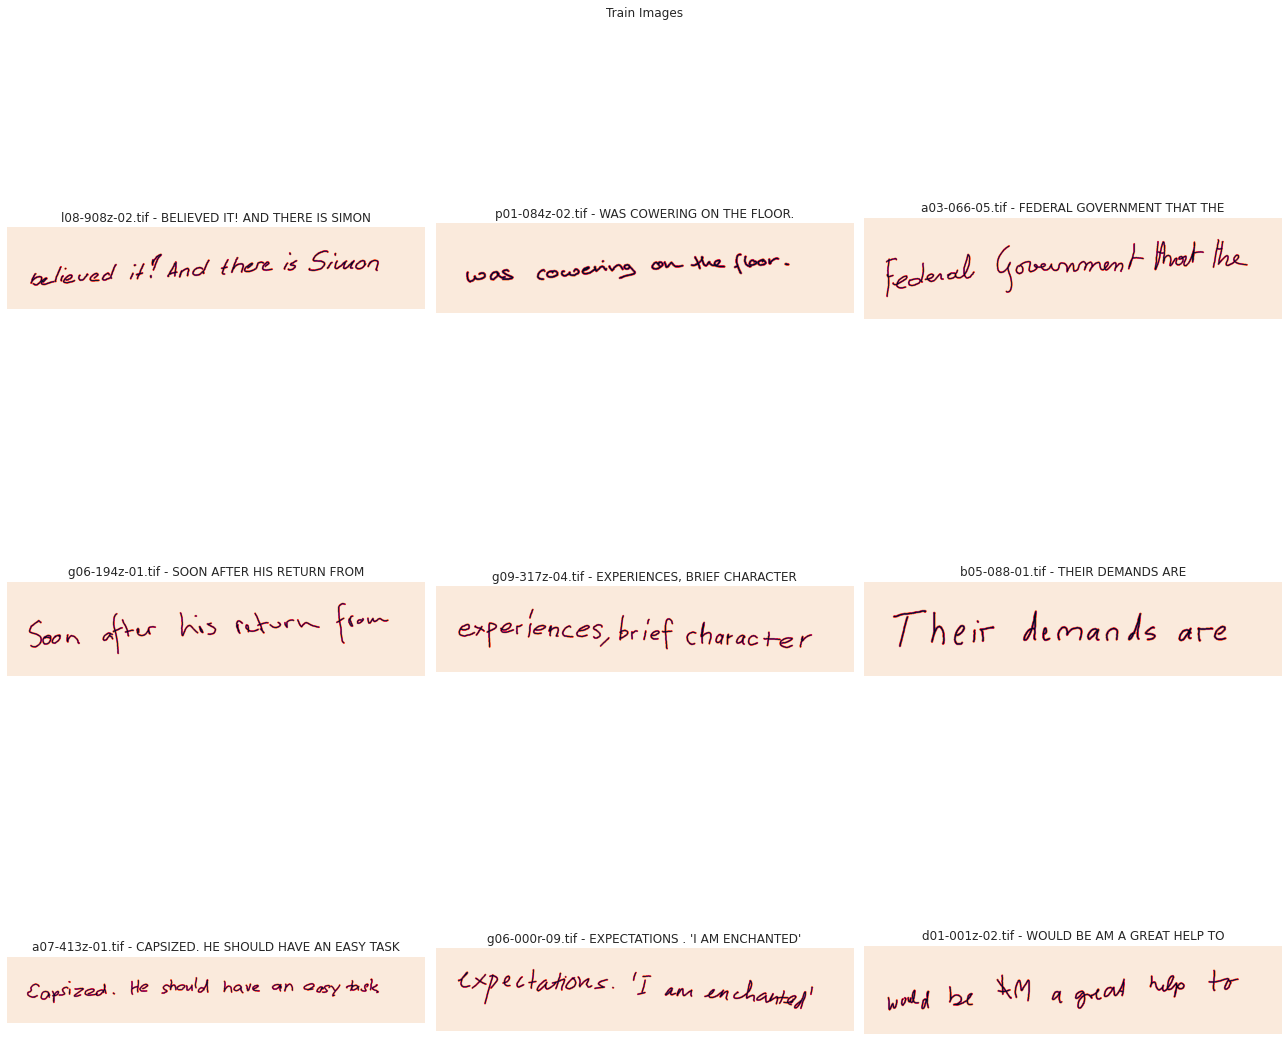

In [13]:
plot_grid(train_df["ImagePath"].tolist(), train_df["Label"].tolist(), title="Train Images")

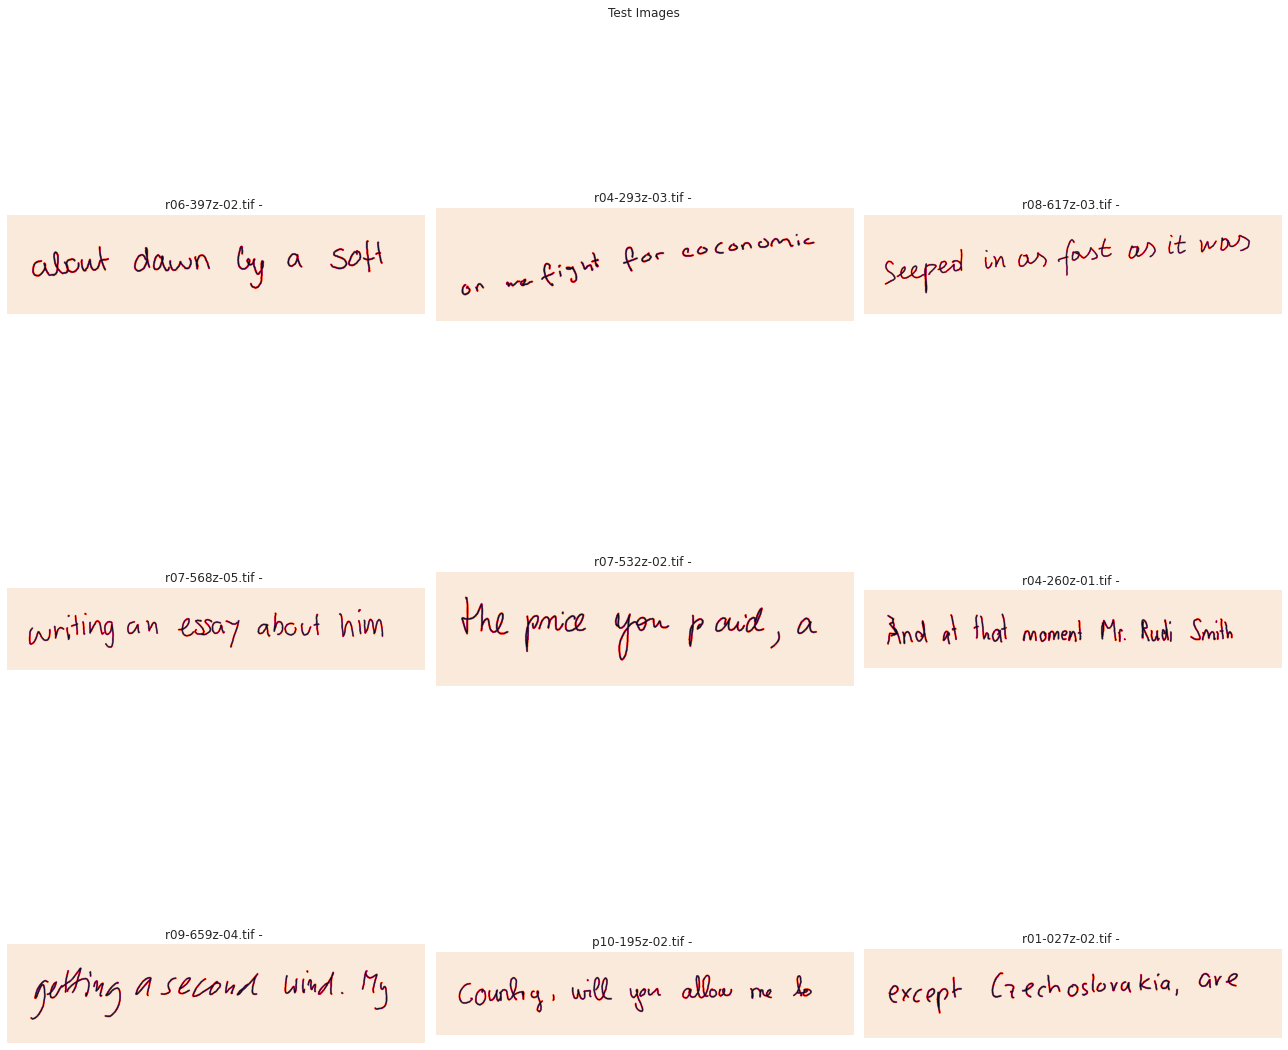

In [14]:
plot_grid(test_files, title="Test Images")

All labels are in *CAPS*. Possibly the model will have trouble representing `d` & `D` both as capital letter - D

## Train Labels

In [15]:
train_df["Length"] = train_df["Label"].astype(str).str.len()

In [16]:
train_df["Length"].describe()

count    11000.000000
mean        29.992000
std          8.647859
min          1.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         76.000000
Name: Length, dtype: float64

In [17]:
train_df["Length"].value_counts()

29    669
28    650
27    599
31    580
30    576
26    570
32    564
25    511
33    500
34    471
24    408
35    401
23    384
36    357
22    324
37    295
38    286
21    235
39    223
40    203
20    189
41    179
42    133
19    131
43    103
44    102
18    100
17     85
45     83
16     76
47     75
46     72
8      56
14     52
15     52
13     51
12     49
48     48
10     48
11     46
9      44
6      43
50     40
49     40
51     39
7      35
53     34
52     27
5      26
54     25
55     21
56     19
4      12
57     10
61      8
58      8
59      7
3       5
60      4
63      3
62      3
64      3
1       2
70      1
76      1
66      1
2       1
65      1
67      1
Name: Length, dtype: int64

## Characters Distribution

### Unique Characters

In [18]:
unique_chars = sorted(list(set(" ".join(train_captions))))
print(unique_chars)

[' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']']


In [19]:
for i in unique_chars:
    try:
        train_df[i] = train_df["Label"].str.count(i)
    except:
        print(i)

(
)
*
+
?
[


In [20]:
# treating regex chars differently
train_df["("] = train_df["Label"].str.count(r"\(")
train_df[")"] = train_df["Label"].str.count(r"\)")
train_df["*"] = train_df["Label"].str.count(r"\*")
train_df["+"] = train_df["Label"].str.count(r"\+")
train_df["?"] = train_df["Label"].str.count(r"\?")
train_df["["] = train_df["Label"].str.count(r"\[")

# overwriting "." since it matches every element
train_df["."] = train_df["Label"].str.count(r"\.")

In [21]:
train_df.sample(n=5)

,ImagePath,Label,Length,,!,"""",#,%,&,',",",-,.,/,0,1,2,3,4,5,6,7,8,9,:,;,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,],(,),*,+,?,[
714,../input/arya-hw-lines/train/train/a06-368z-04...,CALL IT AN AUTUMN BUDGET.,25,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,1,0,1,0,1,0,0,2,1,2,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0
10739,../input/arya-hw-lines/train/train/p04-455z-01...,"""I HAPPENED TO HAVE THE",23,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,4,0,0,3,1,0,0,0,0,1,1,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
10674,../input/arya-hw-lines/train/train/p04-373z-09...,WAS FORCED IN THE OPEN DOORWAY.,31,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2,3,1,0,1,1,0,0,0,0,2,4,1,0,2,1,1,0,0,2,0,1,0,0,0,0,0,0,0,0
10292,../input/arya-hw-lines/train/train/n10-233z-01...,WHAT A COINCIDENCE!,19,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,1,2,0,0,1,2,0,0,0,0,2,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8625,../input/arya-hw-lines/train/train/l07-867z-01...,"""NO, THANK YOU, CLIVE. I SHALL BE",33,6,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,2,0,0,2,2,0,1,3,0,2,2,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0


In [22]:
for i in unique_chars:
    print(f"{i} - {train_df[i].sum()}")

  - 49753
! - 151
" - 1557
# - 77
% - 11
& - 1
' - 863
( - 128
) - 125
* - 2
+ - 9
, - 2608
- - 885
. - 4633
/ - 7
0 - 199
1 - 301
2 - 149
3 - 91
4 - 78
5 - 101
6 - 69
7 - 53
8 - 48
9 - 129
: - 131
; - 75
? - 271
A - 21394
B - 4327
C - 7625
D - 10857
E - 33942
F - 6001
G - 5468
H - 15620
I - 18681
J - 333
K - 2062
L - 10885
M - 6859
N - 18093
O - 20162
P - 5193
Q - 286
R - 16303
S - 17288
T - 24679
U - 7520
V - 2686
W - 5570
X - 505
Y - 4895
Z - 164
[ - 5
] - 4


## Image Dimensions

In [23]:
h_shape=[]
w_shape=[]
aspect_ratio=[]
for idx in tqdm(range(len(train_df))):
    image = cv2.imread(train_df["ImagePath"][idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h_shape.append(image.shape[0])
    w_shape.append(image.shape[1])
    aspect_ratio.append(1.0 * (image.shape[1] / image.shape[0]))

100%|██████████| 11000/11000 [01:44<00:00, 104.90it/s]


In [24]:
len(h_shape), len(w_shape), len(aspect_ratio)

(11000, 11000, 11000)

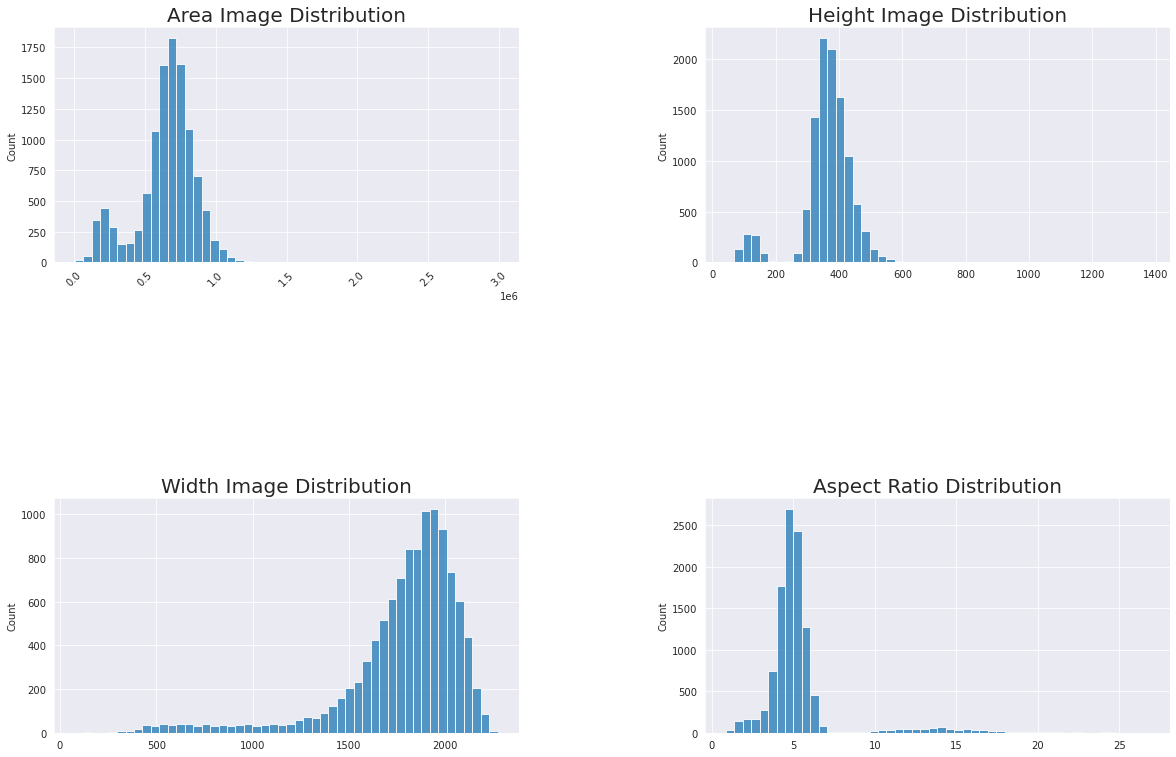

In [25]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=1, wspace=0.4)

plt.subplot(2, 2, 1)
sns.histplot(np.array(h_shape) * np.array(w_shape), bins=50)
plt.xticks(rotation=45)
_ = plt.title("Area Image Distribution", fontsize=20)

plt.subplot(2, 2, 2)
sns.histplot(h_shape, bins=50)
_ = plt.title("Height Image Distribution", fontsize=20)

plt.subplot(2, 2, 3)
sns.histplot(w_shape, bins=50)
_ = plt.title("Width Image Distribution", fontsize=20)

plt.subplot(2, 2, 4)
sns.histplot(aspect_ratio, bins=50)
_ = plt.title("Aspect Ratio Distribution", fontsize=20)

## Problematic Cases

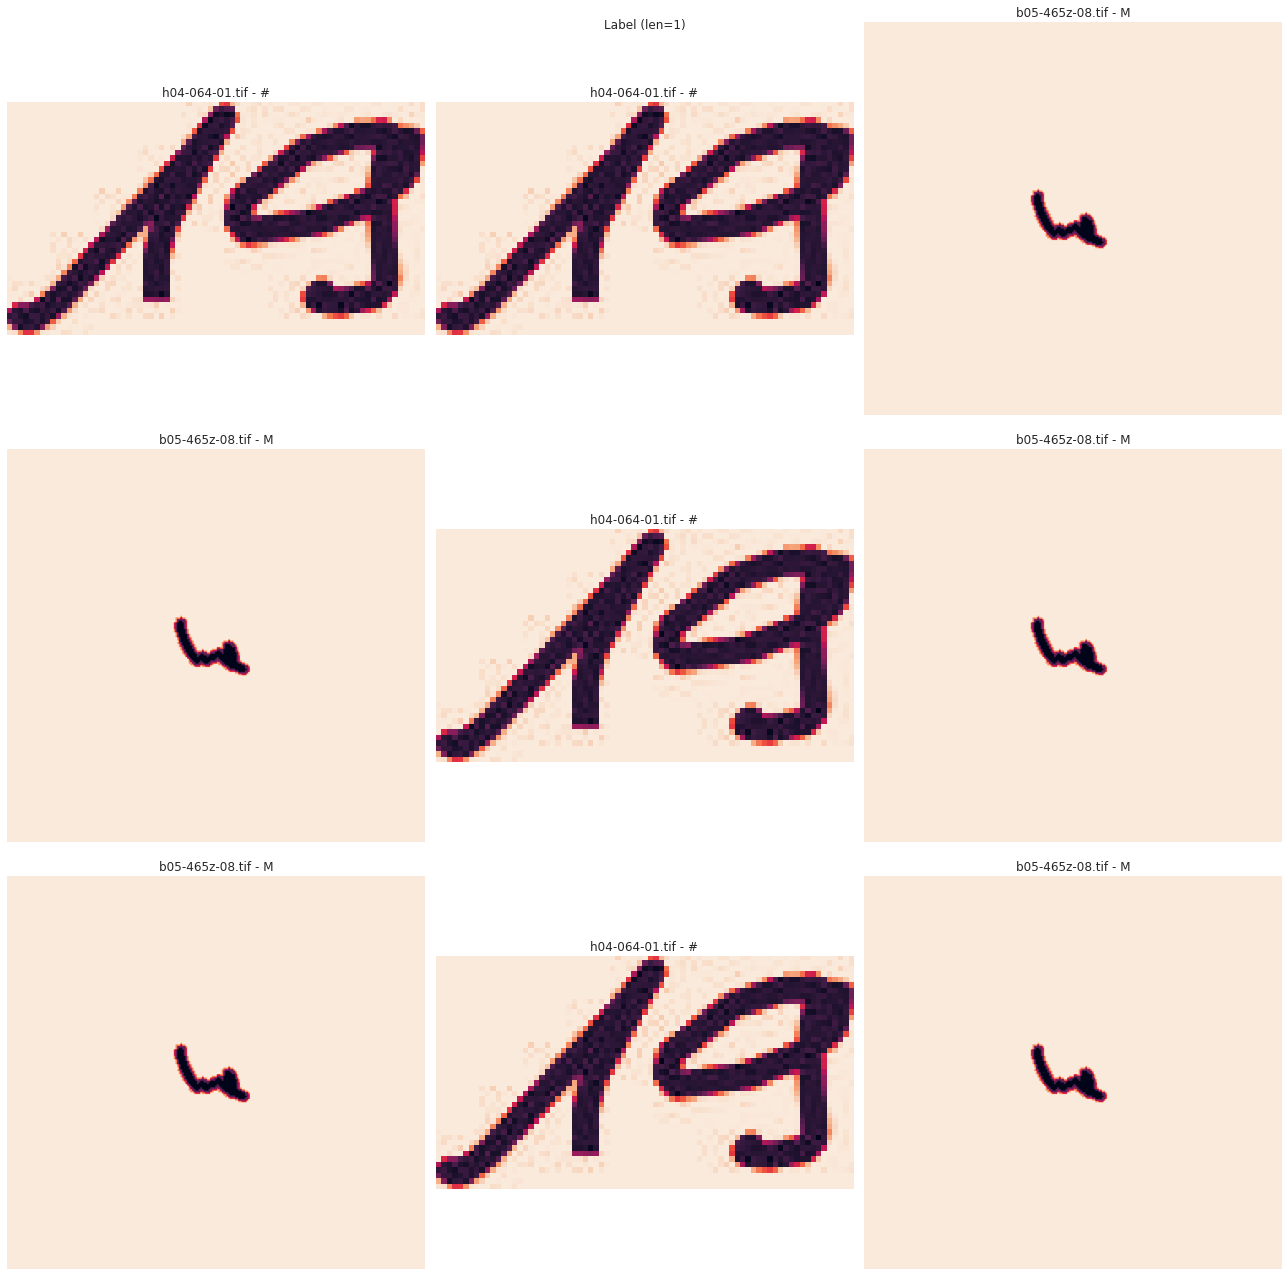

In [26]:
sample = train_df[train_df["Length"]==1]
plot_grid(sample["ImagePath"].tolist(), sample["Label"].tolist(), title="Label (len=1)")

In [27]:
issue = ["g04-036-07.tif", "d09-651z-05.tif", "f06-396z-09.tif", 
         "f04-310z-05.tif", "f07-425z-08.tif", "b06-032-09.tif", 
         "l06-637z-06.tif", "d03-229z-06.tif", "n10-277z-06.tif", 
         "n01-015z-04.tif", "n01-062z-07.tif", "d05-380z-06.tif"]

In [28]:
problematic = train_df.loc[train_df["ImagePath"].str.split("/").str[-1].isin(issue)]

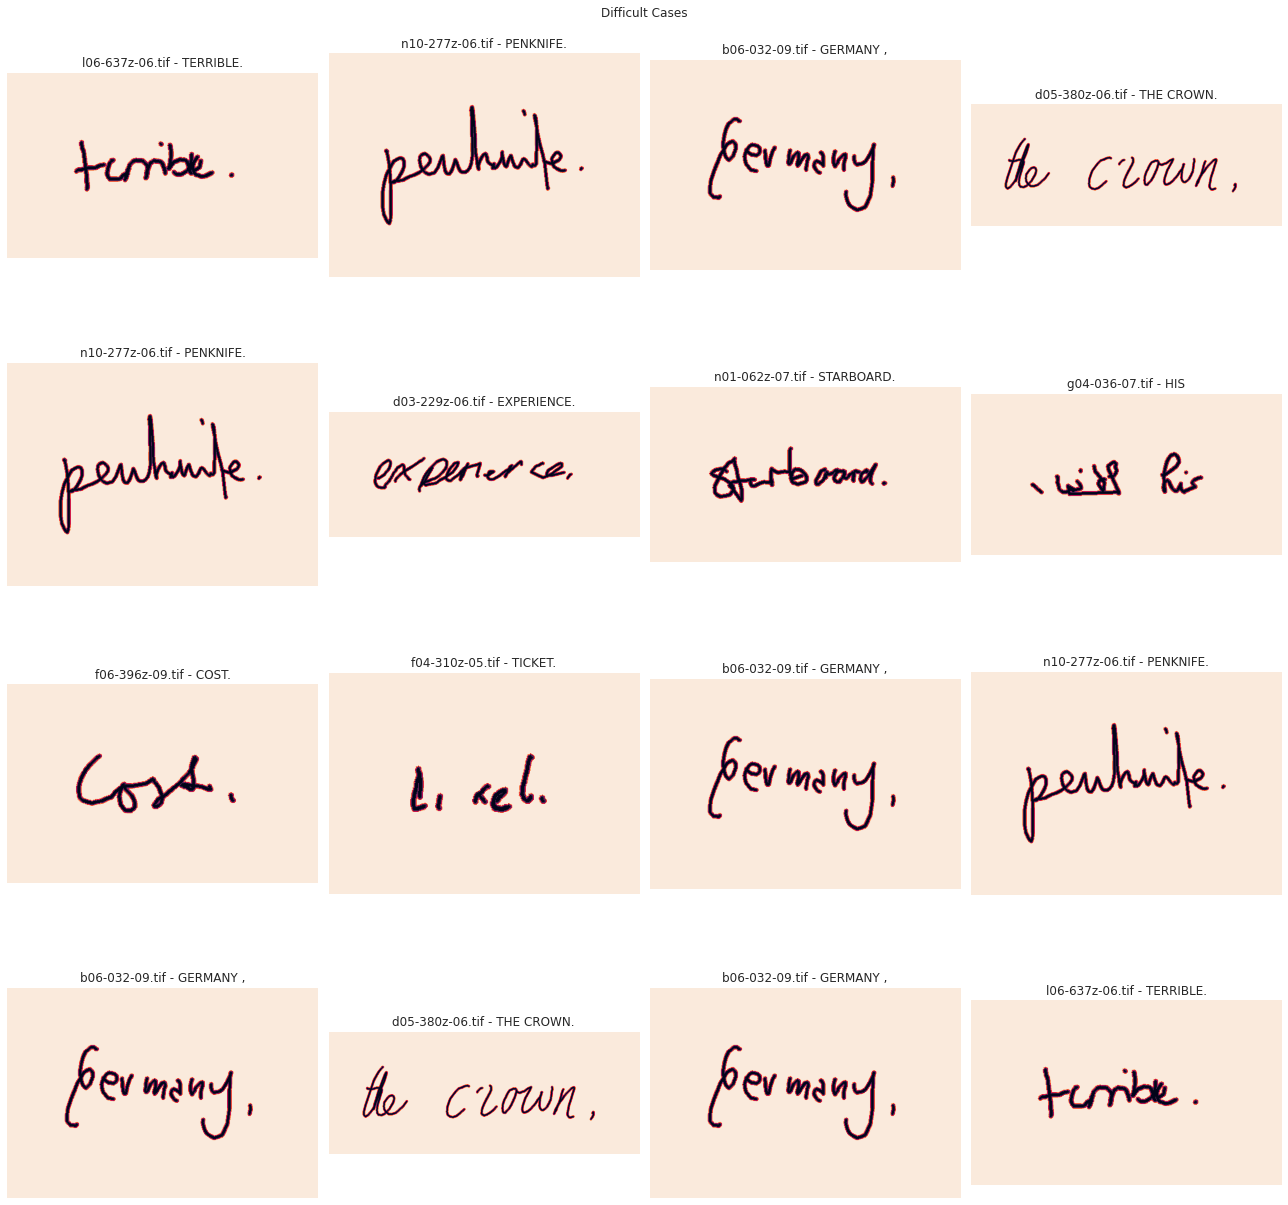

In [29]:
plot_grid(problematic["ImagePath"].tolist(), problematic["Label"].tolist(), h=4, w=4, title="Difficult Cases")

## Stratification
Here, I am testing if `MultiLabelStratifiedKFold` can be used as a validation strategy. Essentially splits will be made based on character counts, such that **each fold has equivalent number of count per character.**

In [30]:
kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=False)

In [31]:
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X=train_df["ImagePath"], y=train_df[unique_chars])):
    print("*"*28)
    print("*"+" "*10+f"FOLD {fold}"+" "*10+"*")
    print("*"*28)
    
    print(f"Train: {len(train_idx)}")
    train_cases = train_df.loc[train_idx]
    for i in unique_chars:
        print(f"{i} - {train_cases[i].sum()}")
    
    print(f"\nValidation: {len(valid_idx)}")
    valid_cases = train_df.loc[valid_idx]
    for i in unique_chars:
        print(f"{i} - {valid_cases[i].sum()}")
    print("\n\n")

****************************
*          FOLD 0          *
****************************
Train: 8801
  - 39919
! - 121
" - 1258
# - 62
% - 11
& - 1
' - 694
( - 101
) - 99
* - 2
+ - 7
, - 2087
- - 704
. - 3717
/ - 5
0 - 161
1 - 245
2 - 120
3 - 73
4 - 61
5 - 83
6 - 56
7 - 41
8 - 37
9 - 104
: - 103
; - 61
? - 217
A - 17092
B - 3454
C - 6094
D - 8703
E - 27139
F - 4833
G - 4401
H - 12568
I - 14981
J - 268
K - 1648
L - 8683
M - 5492
N - 14469
O - 16134
P - 4179
Q - 228
R - 13034
S - 13796
T - 19746
U - 6037
V - 2158
W - 4460
X - 405
Y - 3909
Z - 131
[ - 4
] - 3

Validation: 2199
  - 9834
! - 30
" - 299
# - 15
% - 0
& - 0
' - 169
( - 27
) - 26
* - 0
+ - 2
, - 521
- - 181
. - 916
/ - 2
0 - 38
1 - 56
2 - 29
3 - 18
4 - 17
5 - 18
6 - 13
7 - 12
8 - 11
9 - 25
: - 28
; - 14
? - 54
A - 4302
B - 873
C - 1531
D - 2154
E - 6803
F - 1168
G - 1067
H - 3052
I - 3700
J - 65
K - 414
L - 2202
M - 1367
N - 3624
O - 4028
P - 1014
Q - 58
R - 3269
S - 3492
T - 4933
U - 1483
V - 528
W - 1110
X - 100
Y - 986
Z - 33


I'll keep on updating the notebook as I work on it.